In [1]:
import pandas as pd
import numpy as np
import glob
import laspy
#import open3d as o3d
import cv2

import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from PIL import Image

In [2]:
def GetPathRelations(full_path_to_data):        
    ground_removed_image_paths = []
    laz_point_cloud_paths = []
        
    # Find full path to all images
    for path in glob.glob(full_path_to_data+'/ImagesGroundRemoved/*'):
        ground_removed_image_paths.append(path)
    
    # Find full path to all laz files
    for path in glob.glob(full_path_to_data+'/LazFilesWithHeightRemoved/*'):
        laz_point_cloud_paths.append(path)
            
    ground_removed_image_paths.sort()
    laz_point_cloud_paths.sort()
    assert(len(ground_removed_image_paths)==len(laz_point_cloud_paths))
    return ground_removed_image_paths, laz_point_cloud_paths

In [3]:
def MaxMinNormalize(arr):
    return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

def CastAllXValuesToImage(arr, x_pixels):
    return (MaxMinNormalize(arr))*x_pixels

def CastAllYValuesToImage(arr, y_pixels):
    return (1-MaxMinNormalize(arr))*y_pixels

4095
1001 1001


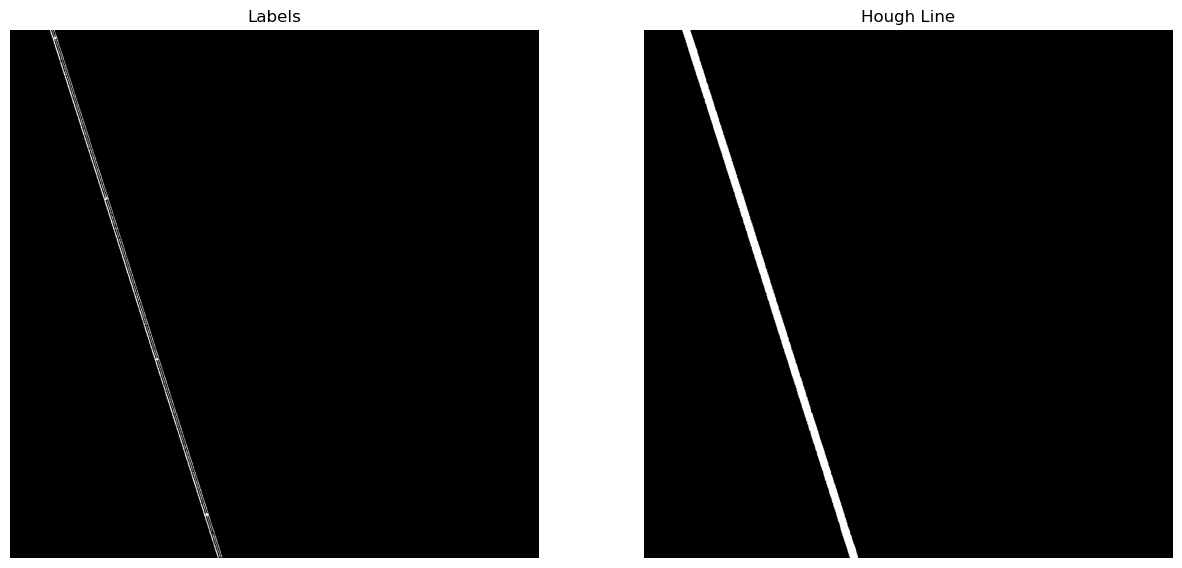

4095
1001 1001


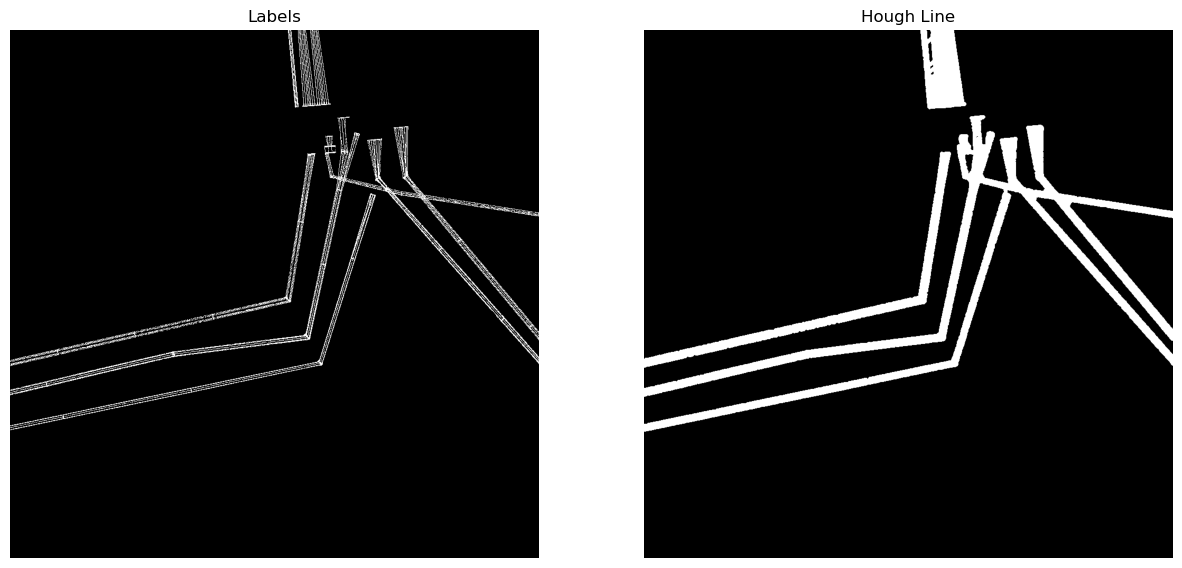

4095
1001 1001


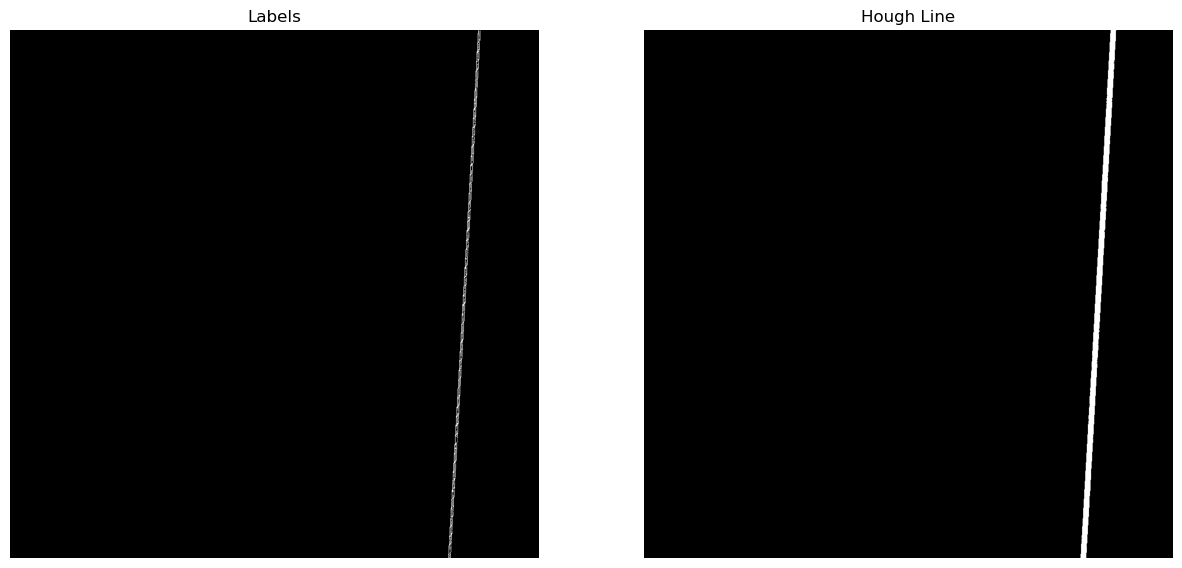

4095
1001 1001


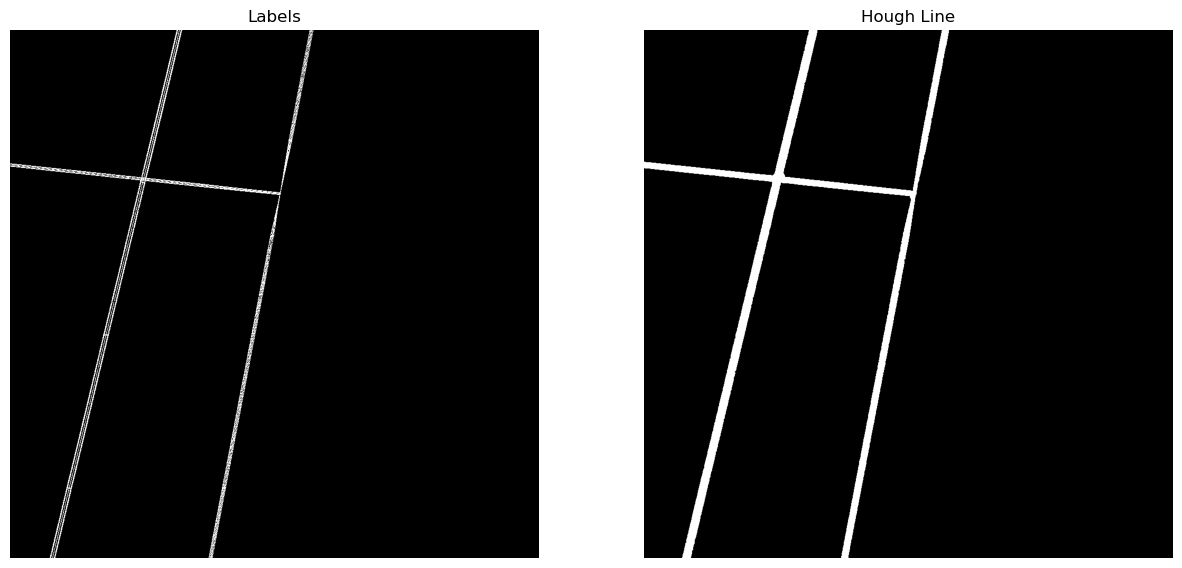

4095
1001 1001


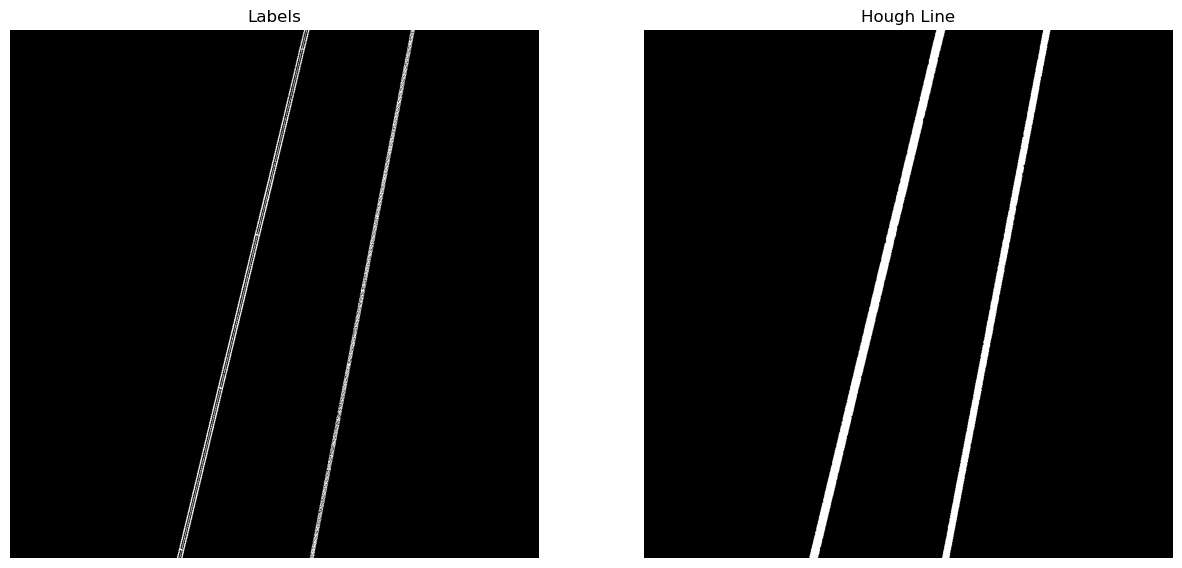

4095
1001 1001


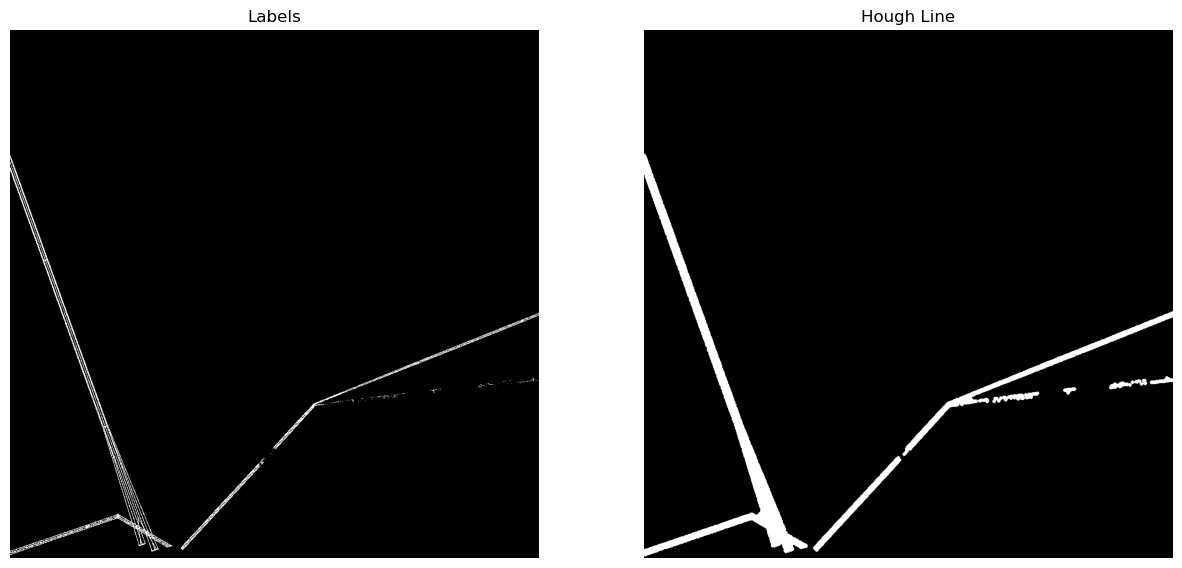

4095
1001 1001


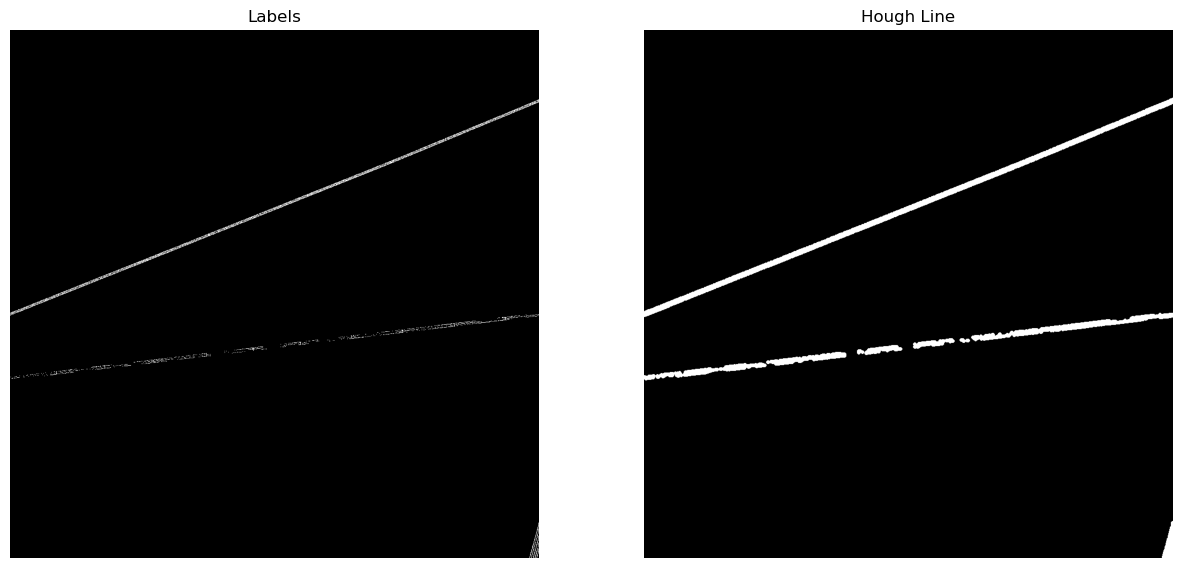

4095
1001 1001


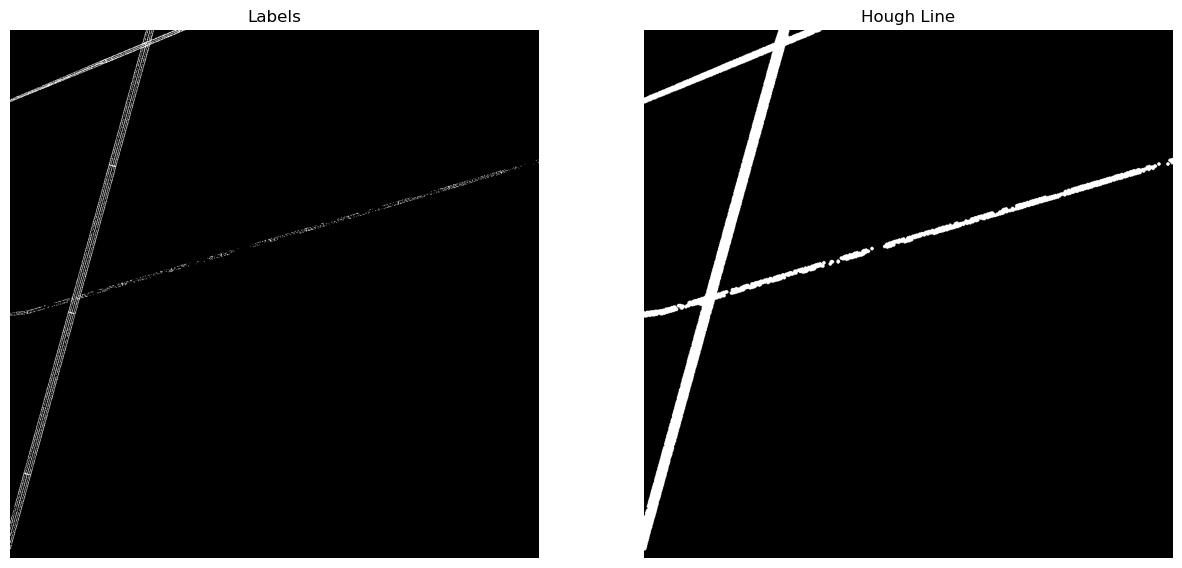

4095
1000 1000


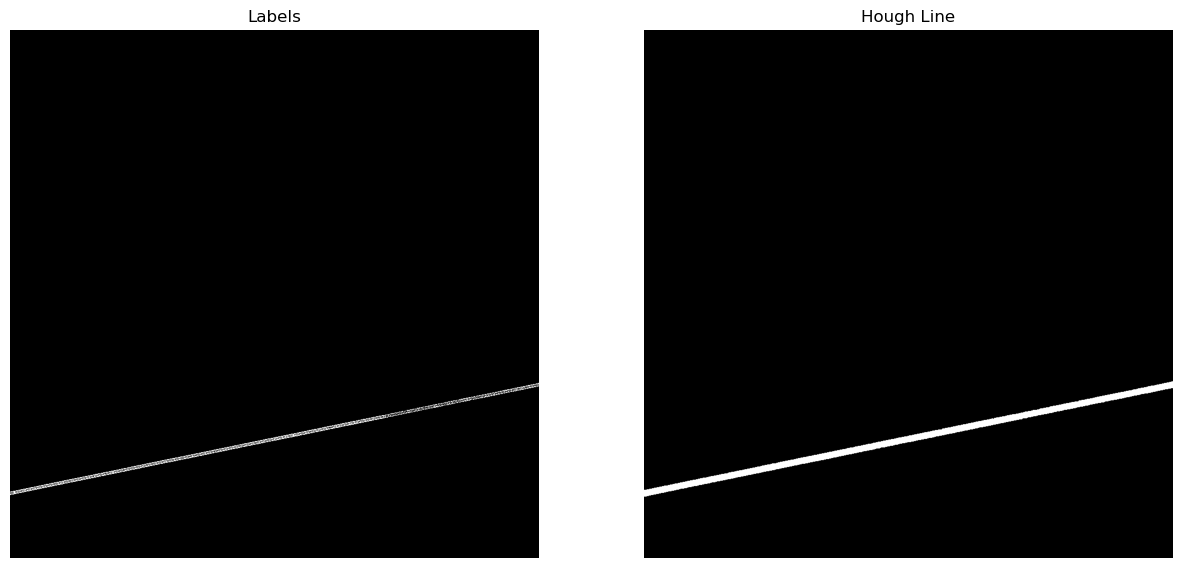

4095
1001 1001


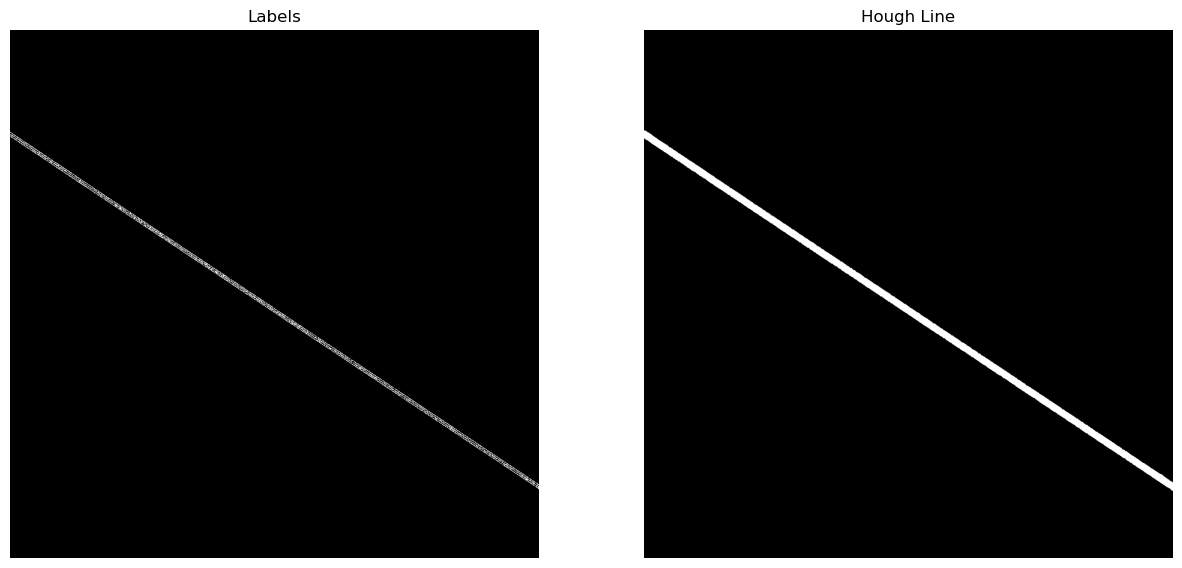

4095
1000 1000


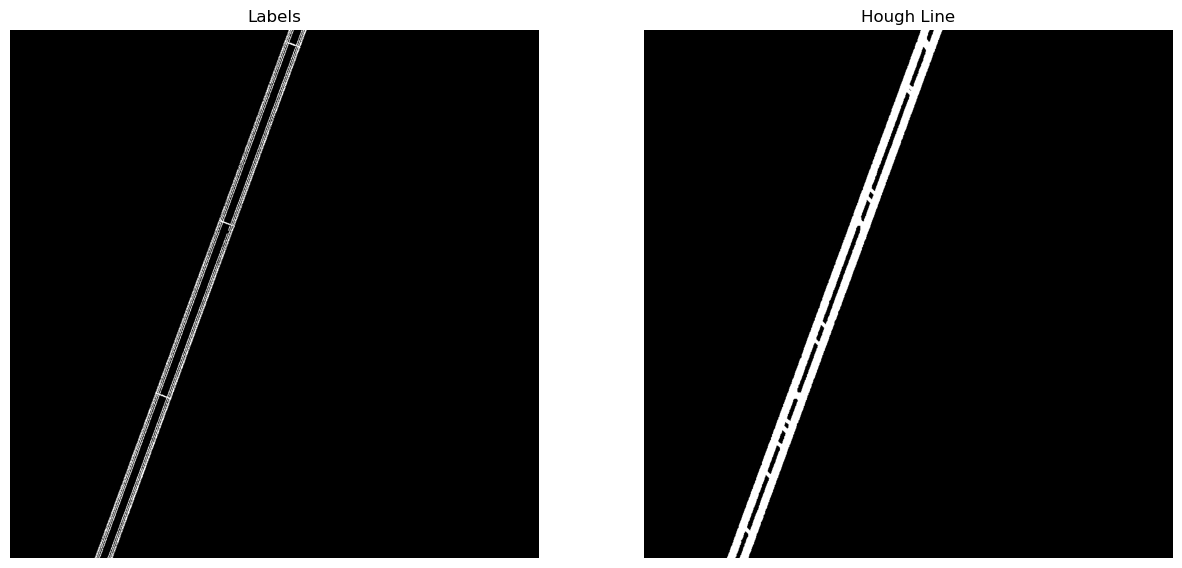

4095
1001 1001


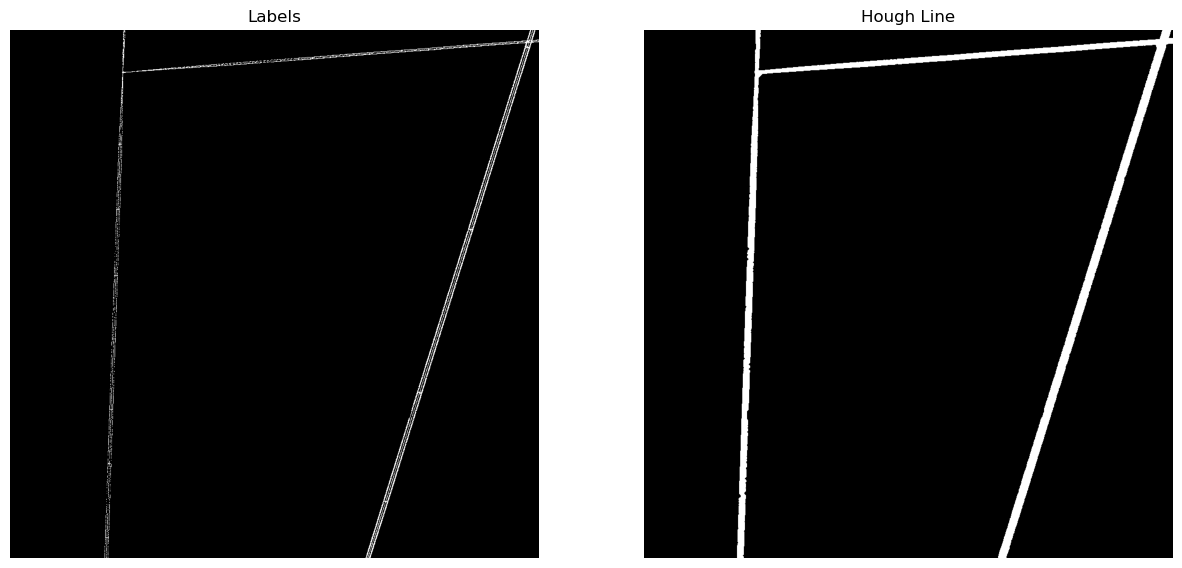

4095
1001 1001


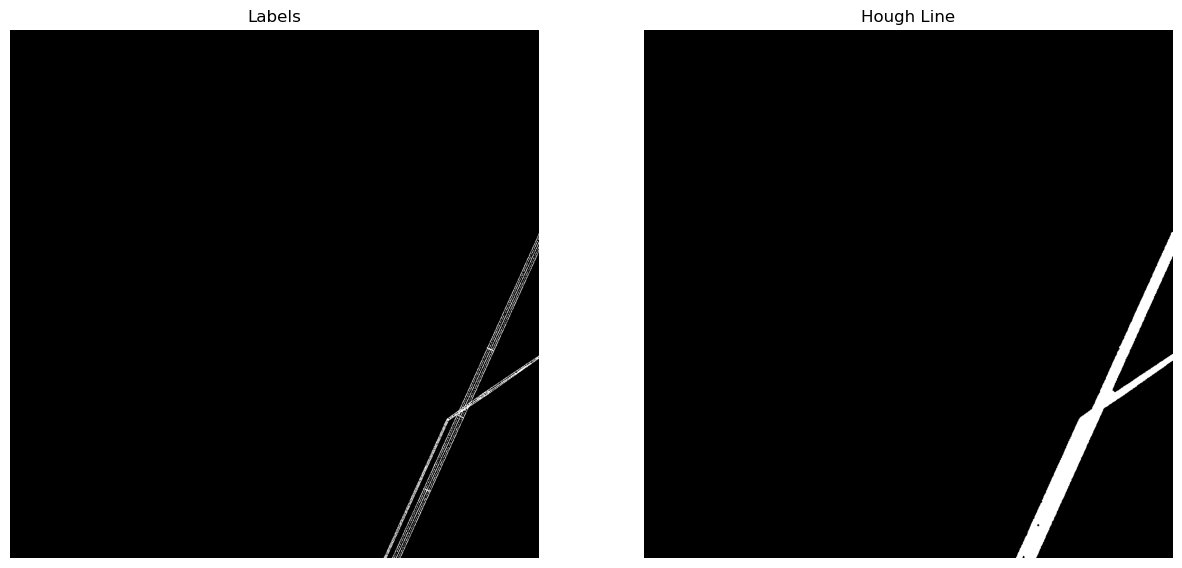

4095
1001 1000


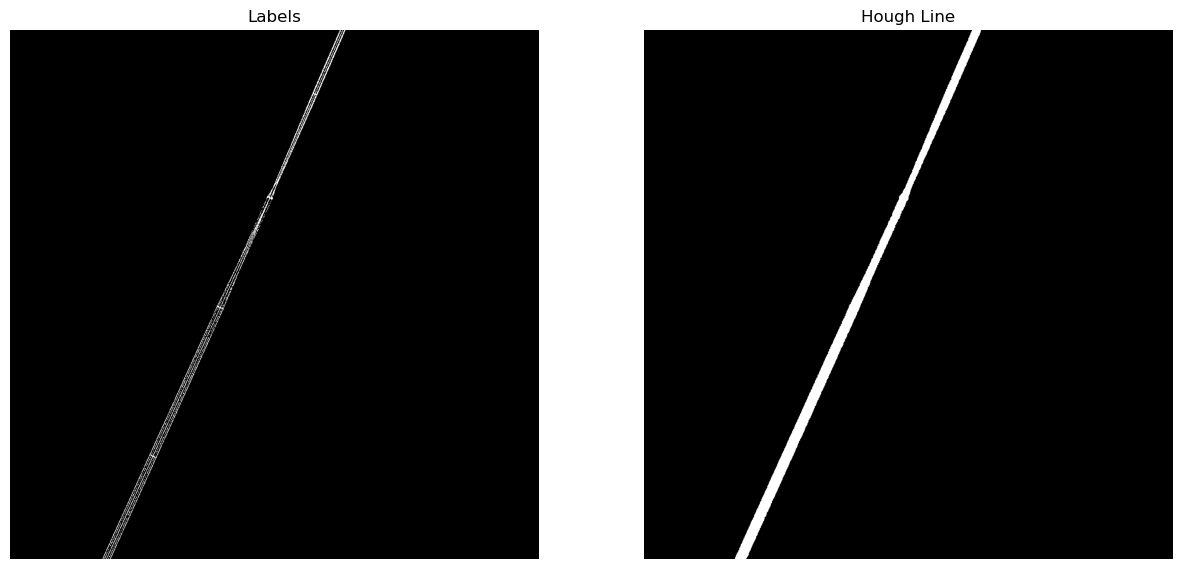

4095
996 1000


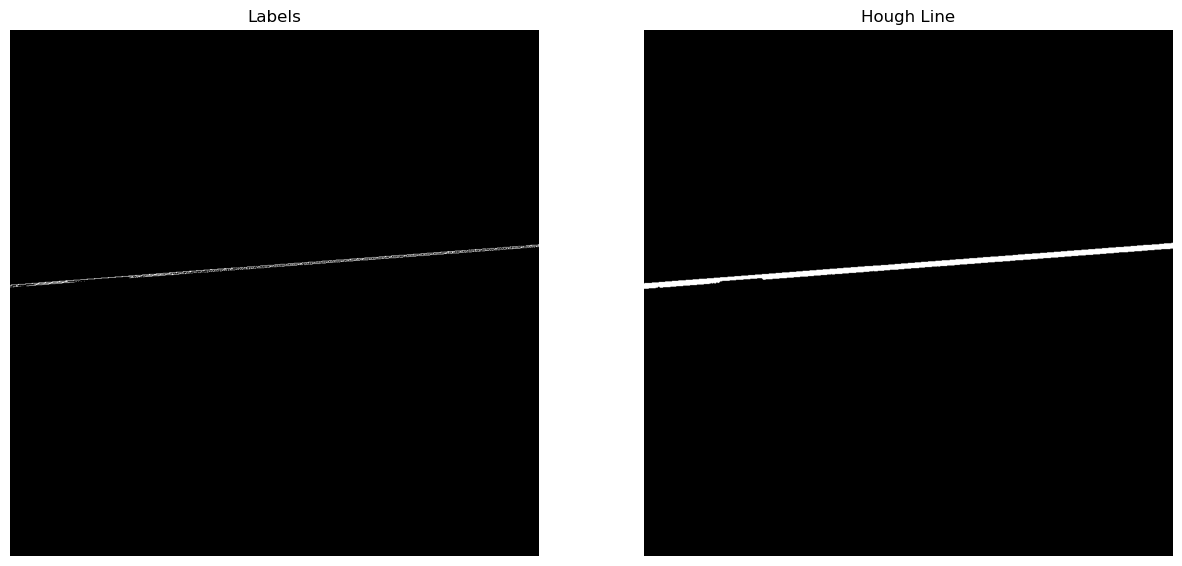

11 11
2 2
2 2


In [4]:
all_path_relations = GetPathRelations("/home/jf/data/test/")
path_tuples = list(zip(*all_path_relations))

transform_img_gray = transforms.Compose(
    [transforms.Resize((1000,1000)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Open images
trainingImages = []
labelImages = []
    
for path in path_tuples:
    image_path, laz_path = path
    
    # Image to training set
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = np.where(image >= 0, image, 0)
    image = image/np.max(image)
    image = (image*255).astype(np.uint8)
    x_pixels, y_pixels = image.shape
    
    image = Image.fromarray(image)
    trainingImages.append(transform_img_gray(image))
    
    # Generate labels 
    las = laspy.read(laz_path, laz_backend=laspy.compression.LazBackend.LazrsParallel)
    
    print(x_pixels, y_pixels)
    
    y_values = np.rint(CastAllXValuesToImage(las.X, y_pixels)).astype(np.int32)
    x_values = np.rint(CastAllYValuesToImage(las.Y, x_pixels)).astype(np.int32)
    
    powerline_mask = (las.classification == 14)
    x_powerline_values = x_values[powerline_mask]
    x_powerline_values = np.where(x_powerline_values < x_pixels, x_powerline_values, x_pixels-1)
    x_powerline_values = np.where(x_powerline_values >= 0, x_powerline_values, 0)
    
    y_powerline_values = y_values[powerline_mask]
    y_powerline_values = np.where(y_powerline_values < y_pixels, y_powerline_values, y_pixels-1)
    y_powerline_values = np.where(y_powerline_values >= 0, y_powerline_values, 0)
    
    labels = np.zeros((x_pixels, y_pixels)).astype(np.uint8)
    for i in range(len(x_powerline_values)):
        labels[x_powerline_values[i], y_powerline_values[i]] = 255
        
    
    linesP = cv2.HoughLinesP(
            labels, # Input edge image
            10, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=0, # Min number of votes for valid line
            minLineLength=0, # Min allowed length of line
            maxLineGap=10
    )
    lines_image = np.zeros_like(labels)
    # Draw the lines
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(lines_image, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3)
    
    
    # Create kernel
    kernel = np.ones((3, 3), np.uint8)
    lines_image = cv2.dilate(lines_image, kernel, iterations=1)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,10))
    ax0.set_title('Labels')
    ax0.imshow(labels, cmap='gray')
    ax1.set_title('Hough Line')
    ax1.imshow(lines_image, cmap='gray')
    ax0.axis('off')
    ax1.axis('off')
    plt.show()

    lines_image = Image.fromarray(lines_image)
    labelImages.append(transform_img_gray(lines_image))
    

    
X_train, X_test, Y_train, Y_test = train_test_split(trainingImages, labelImages, test_size=0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)

print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))


# Setting up sets for trainlodader and validation loader
training_set = []
for i in range(len(X_train)):
    training_set.append([X_train[i], Y_train[i]])
    
validation_set = []
for i in range(len(Y_val)):
    validation_set.append([X_val[i], Y_val[i]])
    
test_set = []
for i in range(len(Y_test)):
    test_set.append([X_test[i], Y_test[i]])

trainloader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=4)

In [5]:
torch.save(valloader, "valloader.pt")
torch.save(testloader, "testloader.pt")
torch.save(trainloader, "trainloader.pt")


In [6]:
trainloader = torch.load("trainloader.pt")
valloader = torch.load("valloader.pt")
testloader = torch.load("testloader.pt")


In [7]:
for i, data in enumerate(trainloader):
    # get the input
    inputs, labels = data
    print(inputs.shape)
    print(labels.shape)
    assert(inputs.shape==labels.shape)
    print(labels)

torch.Size([4, 1, 1000, 1000])
torch.Size([4, 1, 1000, 1000])
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -

In [8]:
class ConvNetRGB(nn.Module):
    def __init__(self):
        super(ConvNetRGB, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding =2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            ).cuda()
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)).cuda()
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding = 2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2)).cuda()
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
            nn.ReLU()).cuda()

        self.down1 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                        stride = 2, kernel_size=3, padding = 1, output_padding=1).cuda()
        
        self.down2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                        kernel_size=3, stride=2, padding=1, output_padding=1).cuda()
        
        self.down3 = nn.ConvTranspose2d(in_channels=64, out_channels=32,
                                        kernel_size=3, stride=2, padding=1, output_padding=1).cuda()
        
        self.down4 = nn.ConvTranspose2d(in_channels=32, out_channels=1,
                                        kernel_size=3, stride=1, padding=1).cuda()
        

        
    def forward(self, x):
        out = self.layer1(x)
        # print(f"self.layer1 {out.shape}")
        out = self.layer2(out)
        # print(f"self.layer2 {out.shape}")
        out = self.layer3(out)
        # print(f"self.layer3 {out.shape}")
        out = self.layer4(out)
        # print(f"self.layer4 {out.shape}")
        out = self.down1(out)
        # print(f"self.down1 {out.shape}")
        out = self.down2(out)
        # print(f"self.down2 {out.shape}")
        out = self.down3(out)
        # print(f"self.down3 {out.shape}")
        out = self.down4(out)
        # print(f"self.down4 {out.shape}")
        
        #out = torch.sigmoid(out)
        return out

In [9]:
def ConvNetTraining(trainloader, valloader, Conv, lossFunction, learning_rate, epochs):
    model = Conv
    num_epochs = epochs
    criterion = lossFunction.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # loss arrays for figures
    TrainingLossArray = []
    ValidationLossArray = []
    
    early_stopping = 20
    notImproved = 0
    bestLoss = None
    bestModel = None
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for j, data in enumerate(trainloader):
            # get the input
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize            
            outputs = model(inputs.cuda())
            loss = criterion(outputs.cuda(), labels.cuda())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Appending the mean running loss
        TrainingLossArray.append(running_loss/(j+1))
        
        # print("Training loss: ", running_loss/j)
        
        # Finding validation loss
        validation_loss = 0
        for i, data in enumerate(valloader):
            # get the inputs
            inputs, labels = data
            
            #Calculates loss
            outputs = model(inputs.cuda())            
            loss = criterion(outputs.cuda(), labels.cuda())      
            validation_loss += loss.item()
        # Appending the mean validation loss
        ValidationLossArray.append(validation_loss/(i+1))
        # print("Validation loss: ", validation_loss/i)
        print(f"epoch = {epoch}, Validation loss: {validation_loss/(i+1):.7f}, Training loss: {running_loss/(j+1):.7f}")
        print(f"LR = {scheduler.get_last_lr()[0]}")
        
        # Initialising params for early stopping
        if bestLoss == None:
            bestLoss = validation_loss
        
        # Checks for early stopping
        #early_stop_crit = np.isclose(validation_loss, bestLoss, rtol=1e-06, atol=1e-08)
        
        if validation_loss <= bestLoss:
            notImproved = 0
            bestLoss = validation_loss
            bestModel = model
            torch.save(bestModel, "bestModel.pth")
        else:
            notImproved +=1
        # Converges if the training has not improved for a certain amount of iterations
        if notImproved >= early_stopping:
            break
        scheduler.step()
        
    return bestModel, ValidationLossArray, TrainingLossArray

In [11]:
bestModel, ValidationLossArray, TrainingLossArray = ConvNetTraining(trainloader, valloader, ConvNetRGB(), nn.MSELoss(), 0.001, 1000)

epoch = 0, Validation loss: 0.2484396, Training loss: 0.7413875
LR = 0.001
epoch = 1, Validation loss: 0.1275417, Training loss: 0.2480497
LR = 0.0009000000000000001
epoch = 2, Validation loss: 0.1025070, Training loss: 0.1817390
LR = 0.0008100000000000001
epoch = 3, Validation loss: 0.0981731, Training loss: 0.1392792
LR = 0.000729
epoch = 4, Validation loss: 0.0919022, Training loss: 0.1328797
LR = 0.0006561000000000001
epoch = 5, Validation loss: 0.0796757, Training loss: 0.1265867
LR = 0.00059049
epoch = 6, Validation loss: 0.0778355, Training loss: 0.1259248
LR = 0.000531441
epoch = 7, Validation loss: 0.0810889, Training loss: 0.1190336
LR = 0.0004782969
epoch = 8, Validation loss: 0.0754793, Training loss: 0.1146520
LR = 0.00043046721
epoch = 9, Validation loss: 0.0743141, Training loss: 0.1131116
LR = 0.000387420489
epoch = 10, Validation loss: 0.0724945, Training loss: 0.1172520
LR = 0.0003486784401
epoch = 11, Validation loss: 0.0737507, Training loss: 0.1152603
LR = 0.000313

KeyboardInterrupt: 

In [ ]:
np.min(ValidationLossArray)

0.0689263567328453

In [12]:
bestModel = torch.load("bestModel.pth")

0
tensor(-0.1603)
tensor(1.)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
1
tensor(-0.1531)
tensor(1.)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


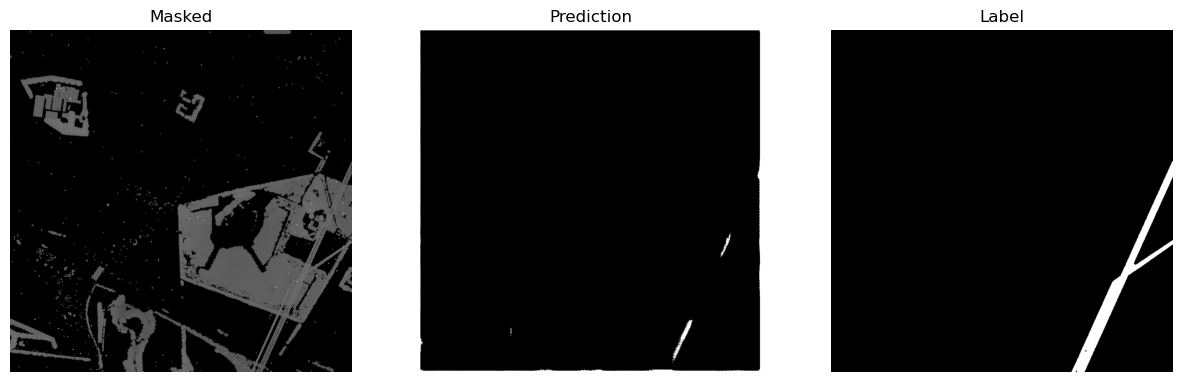

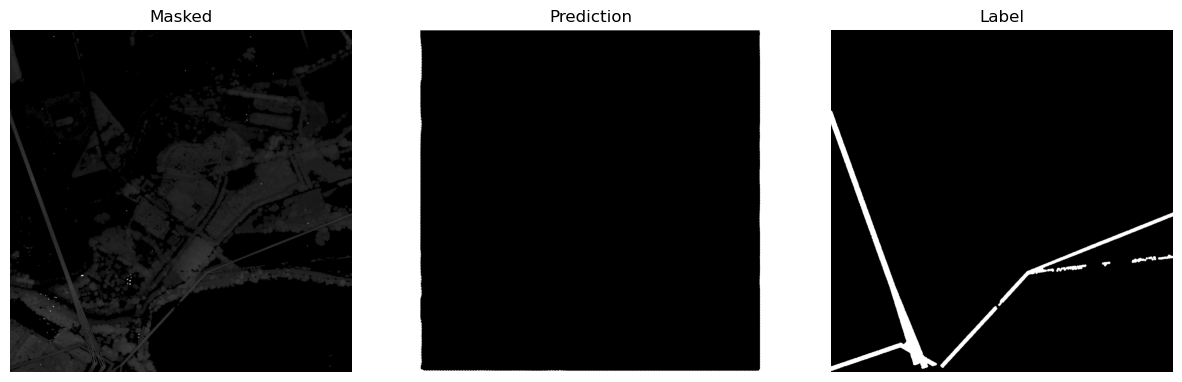

In [13]:
with torch.no_grad():
    for j, data in enumerate(testloader):
        # get the input
        batch_input, batch_labels = data
        for i in range(len(batch_labels)):
            print(i)
            masked, labels = batch_input[i], batch_labels[i]
            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,10))

            ax0.set_title('Masked')
            ax0.imshow(((torch.squeeze(masked.detach())).numpy()),cmap='gray')


            ax1.set_title('Prediction')
            outputs = torch.squeeze(bestModel(masked.cuda())).detach().cpu()
            print(torch.max(outputs))
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > 0.3 ).float()
            print(torch.max(outputs))
            print(outputs)

            ax1.imshow(((torch.squeeze(outputs.detach())).numpy()),cmap='gray')

            ax2.set_title("Label")
            ax2.imshow(((torch.squeeze(labels.detach())).numpy()),cmap='gray')

            ax0.axis('off')
            ax1.axis('off')
            ax2.axis('off')


0
tensor(-0.1604)
tensor([[-0.2144, -0.3957, -0.5711,  ..., -0.3047, -0.3486, -0.1891],
        [-0.3741, -0.8537, -0.8722,  ..., -0.6509, -0.5599, -0.4249],
        [-0.4046, -0.8539, -0.8712,  ..., -0.6726, -0.5723, -0.4614],
        ...,
        [-0.3080, -0.6957, -0.6960,  ..., -0.5729, -0.4722, -0.3587],
        [-0.2507, -0.5728, -0.5745,  ..., -0.4804, -0.3829, -0.3358],
        [-0.1604, -0.4156, -0.4004,  ..., -0.3261, -0.2767, -0.2155]])
tensor(1.)
1
tensor(-0.1604)
tensor([[-0.2147, -0.3961, -0.5717,  ..., -0.3076, -0.3528, -0.1914],
        [-0.3745, -0.8545, -0.8731,  ..., -0.6572, -0.5645, -0.4290],
        [-0.4049, -0.8546, -0.8720,  ..., -0.6793, -0.5769, -0.4656],
        ...,
        [-0.3081, -0.6958, -0.6962,  ..., -0.5729, -0.4722, -0.3587],
        [-0.2508, -0.5730, -0.5746,  ..., -0.4804, -0.3829, -0.3358],
        [-0.1604, -0.4158, -0.4005,  ..., -0.3261, -0.2767, -0.2155]])
tensor(1.)
2
tensor(-0.1604)
tensor([[-0.2147, -0.3961, -0.5717,  ..., -0.3076, -0.35

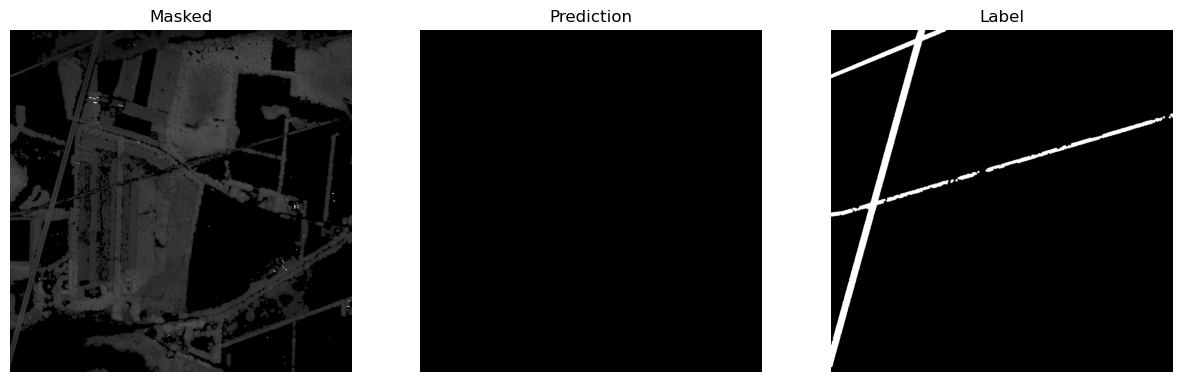

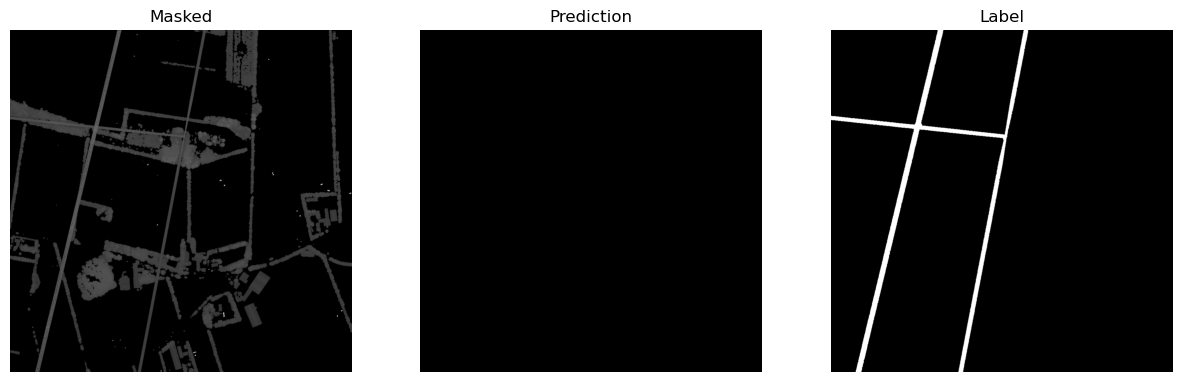

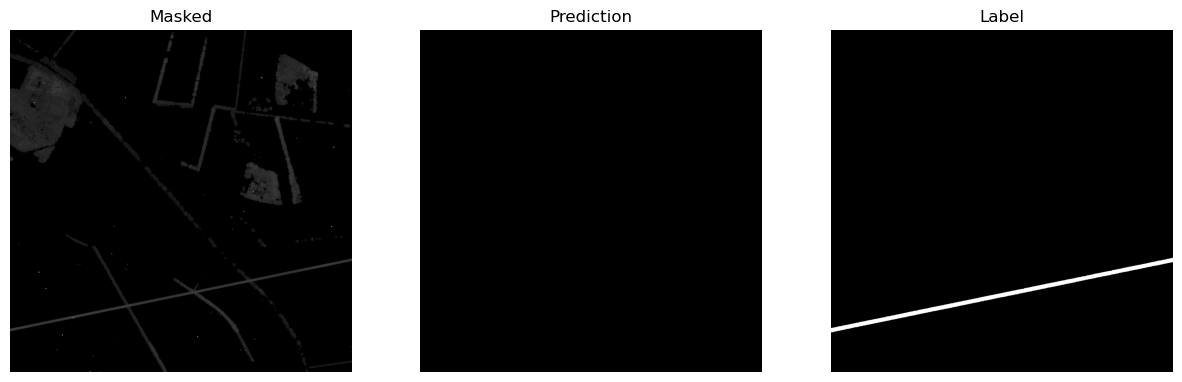

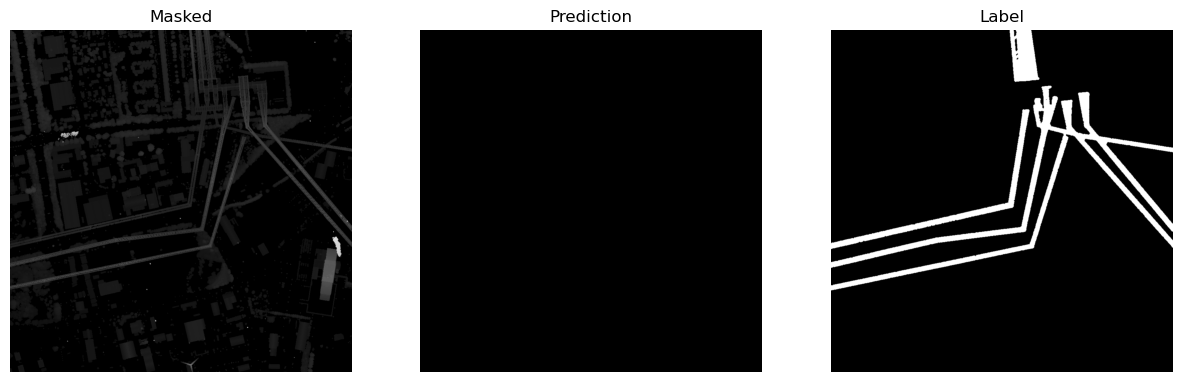

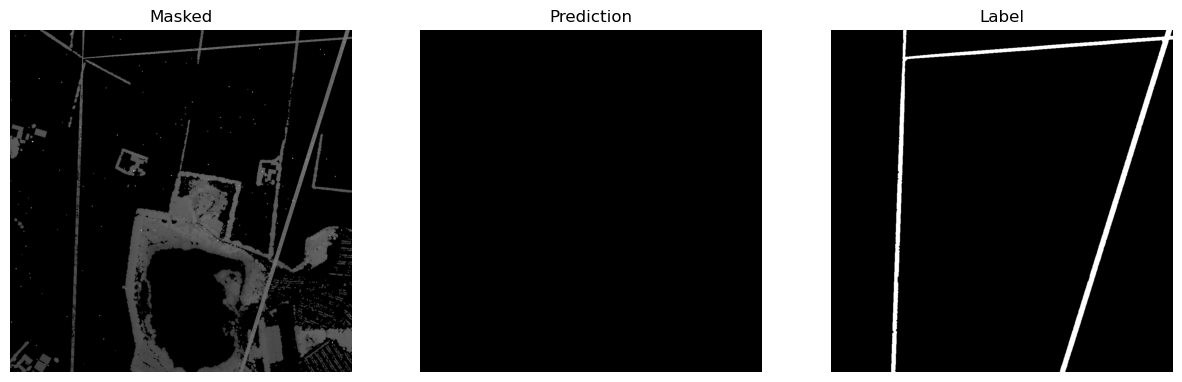

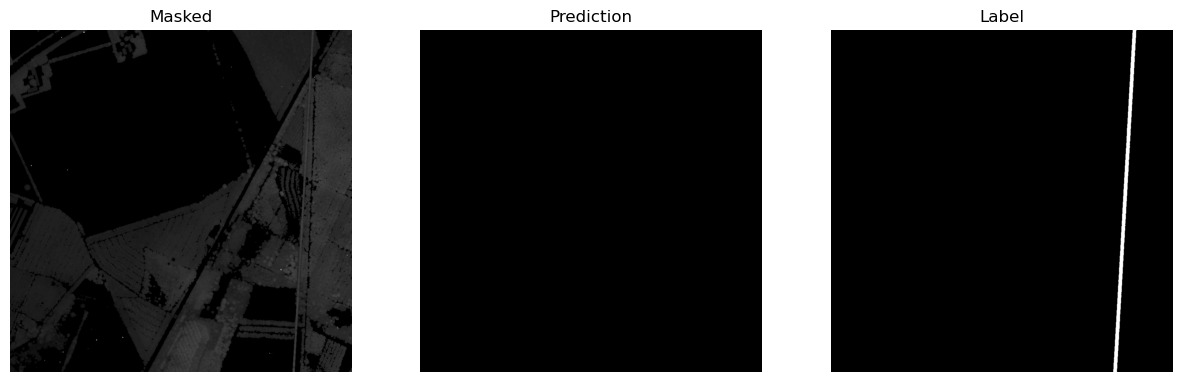

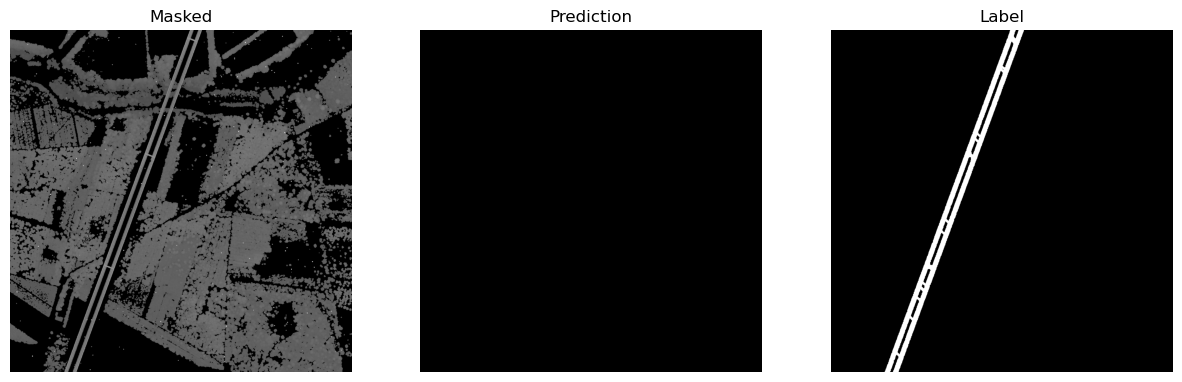

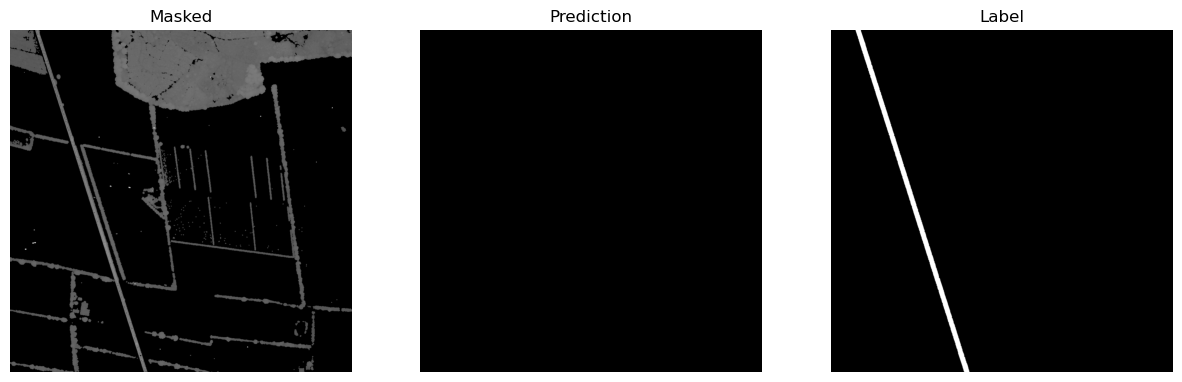

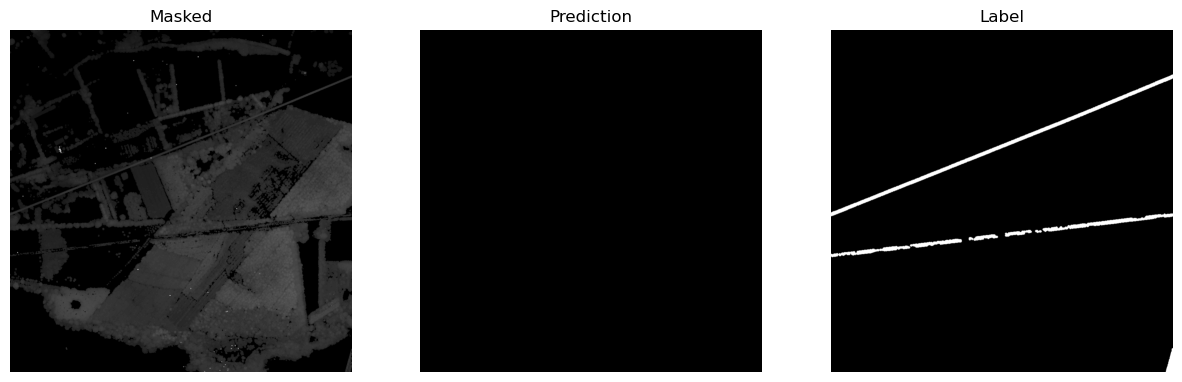

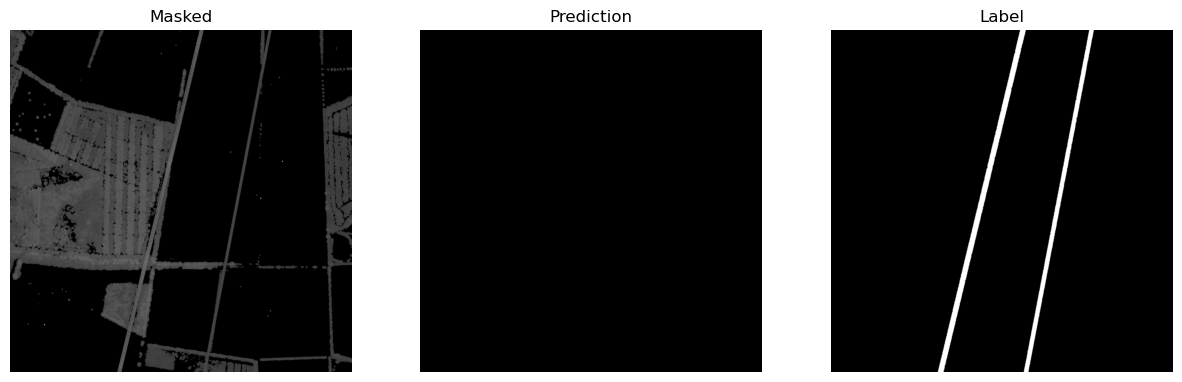

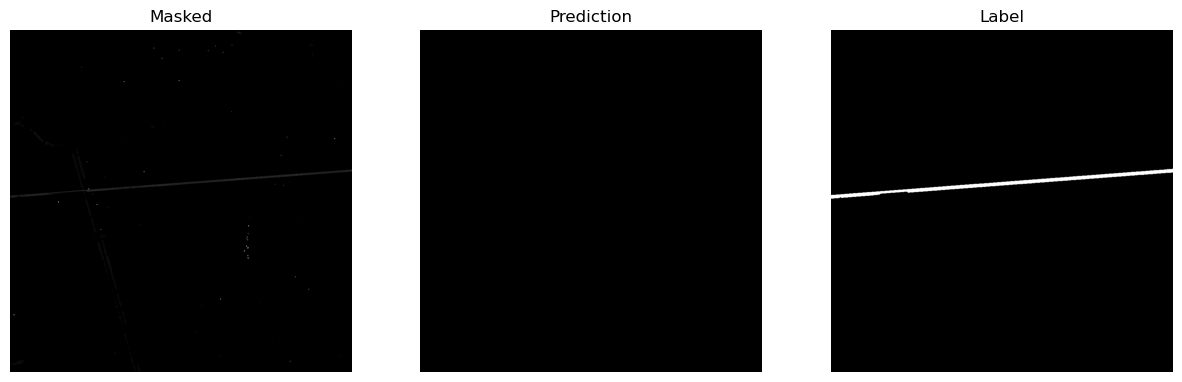

In [23]:
with torch.no_grad():
    for j, data in enumerate(trainloader):
        # get the input
        batch_input, batch_labels = data
        for i in range(len(batch_labels)):
            print(i)
            masked, labels = batch_input[i], batch_labels[i]
            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,10))

            ax0.set_title('Masked')
            ax0.imshow(((torch.squeeze(masked.detach())).numpy()),cmap='gray')


            ax1.set_title('Prediction')
            outputs = torch.squeeze(bestModel(masked.cuda())).detach().cpu()
            print(torch.max(outputs))
            print(outputs)
            # outputs = (outputs > 0.01 ).float()
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > 0.0 ).float()
            print(torch.max(outputs))
            # print(outputs)

            ax1.imshow(((torch.squeeze(outputs.detach())).numpy()),cmap='gray')

            ax2.set_title("Label")
            ax2.imshow(((torch.squeeze(labels.detach())).numpy()),cmap='gray')

            ax0.axis('off')
            ax1.axis('off')
            ax2.axis('off')
